In [1]:
import os
import pandas as pd
import zipfile
import librosa, librosa.display
from tqdm.notebook import tqdm

# Data Ingestion

In [3]:
zipped_audio = 'Audio MNIST.zip'

In [4]:
with zipfile.ZipFile(zipped_audio, 'r') as zip_ref:
    # Extract all the contents into the current directory
    zip_ref.extractall('./MNIST_Data')  # if no argument is passed, files will be extracted to the current working directory

print(f'Extracted the contents of {zipped_audio} into the specified directory.')

Extracted the contents of Audio MNIST.zip into the specified directory.


In [2]:
# Get the list of all the files and folders in the current directory
files_and_folders = os.listdir('./Audio/free-spoken-digit-dataset-master')
print(files_and_folders)

['pip_requirements.txt', 'recordings', 'metadata.py', '__init__.py', 'utils', 'README.md', '.gitignore', 'acquire_data']


The actual .wav files are stored in the ./Audio/free-spoken-digit-dataset-master/recordings/ path.

In [9]:
record_path='./Audio/free-spoken-digit-dataset-master/recordings/'

Converting the .wav files into their numerical representations and inserting them into a dataframe that is understandable within python using pandas.

In [42]:
audio_df=pd.DataFrame(columns=['raw_data','frame_rate', 'duration','digit'])
for i in tqdm(os.listdir(record_path)):
    # method to load all the audio files from directory and calc frame rate
    raw_data,frame_rate=librosa.load(record_path+i)
    # method to infer duration from data and frame rate using librosa
    duration=librosa.get_duration(y=raw_data,sr=frame_rate)
    # inserting the extracted data into the dataframe
    audio_df.loc[len(audio_df.index)]=[raw_data,frame_rate,duration,i.split('_')[0]] # i.split is the file name (digit name)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [43]:
audio_df.shape

(3000, 4)

# Exploratory Data Analysis

## Visualizing the wave forms of different digit classes to understand how wave shape differs by each

In [58]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

In [45]:
audio_df.head()

,raw_data,frame_rate,duration,digit
0,"[0.0007090622, 8.305741e-05, -0.0008284228, -0...",22050,0.337415,5
1,"[4.3985827e-05, -0.00015679716, -0.00040316404...",22050,0.305760,3
2,"[-0.00052017445, -0.00063179934, -0.0005419, -...",22050,0.337007,1
3,"[-0.0016748044, -0.0023194065, -0.0016845848, ...",22050,0.319501,2
4,"[-5.8825585e-06, 2.0447591e-05, 6.755755e-05, ...",22050,0.383129,4


In [46]:
def visualize_digit(num_to_plot, digit_to_plot):
    num_plots = 0
    # removing 1 bc of zero indexing
    num_to_plot -= 1
    for i in range(len(audio_df)):
        digit = audio_df.iloc[i, 3]
        if digit == str(digit_to_plot):
            plt.figure(figsize = (16, 6))
            raw_data = audio_df.iloc[i, 0]
            frame_rate= audio_df.iloc[i, 1]
            librosa.display.waveshow(y = raw_data, sr = frame_rate, color = "#A300F9")
            plt.title('Digit: ' + digit, fontsize=24)
            plt.show()
            if num_plots == num_to_plot:
                break
            num_plots += 1

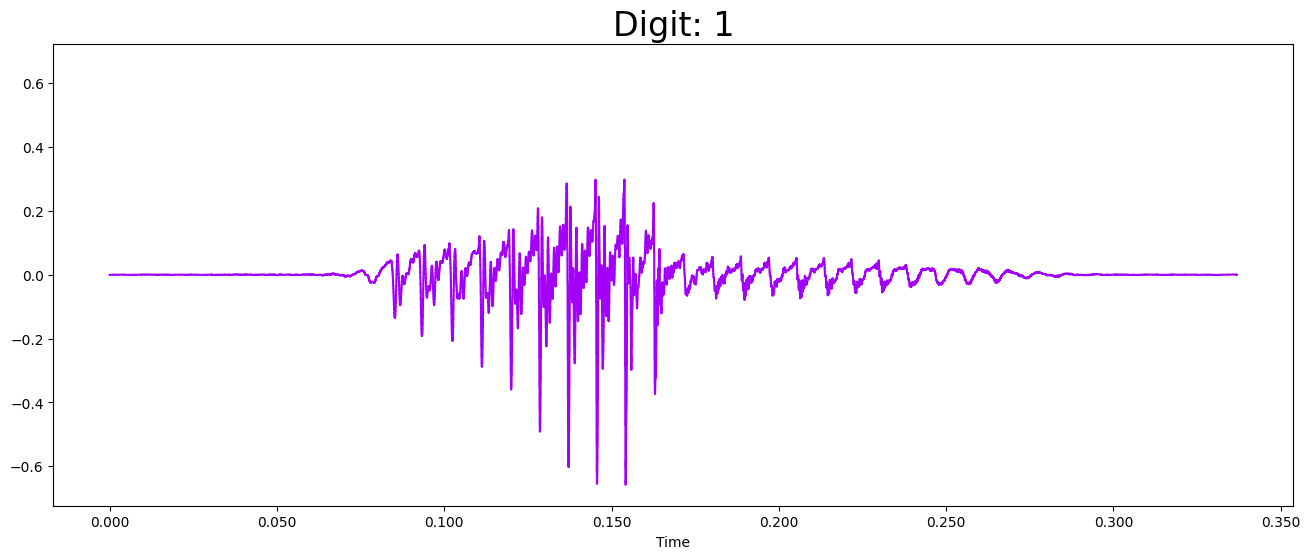

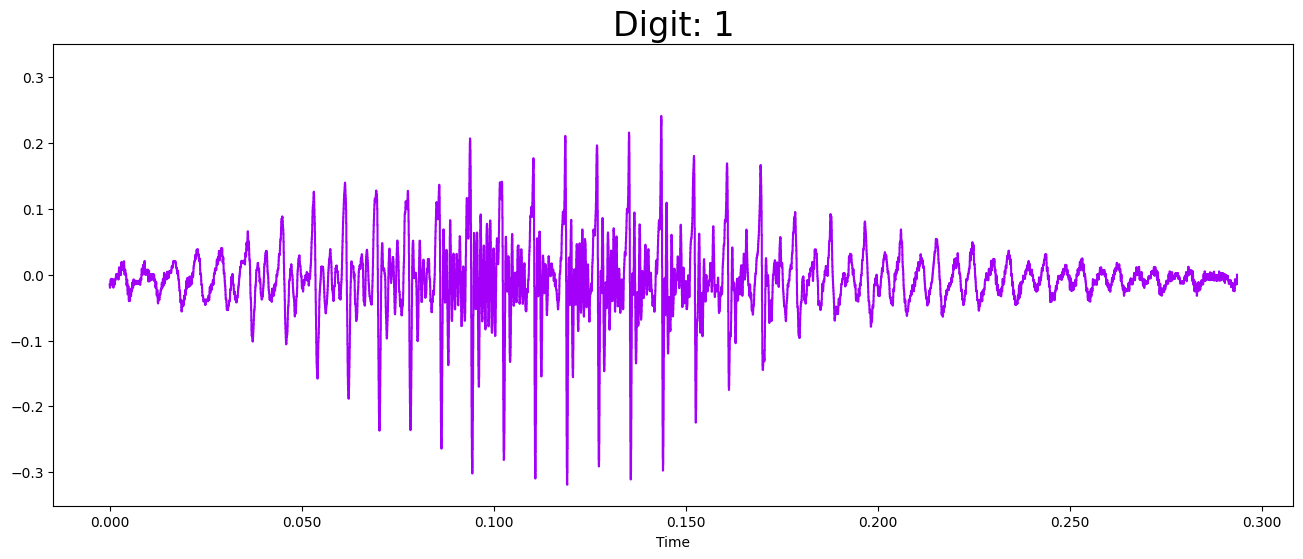

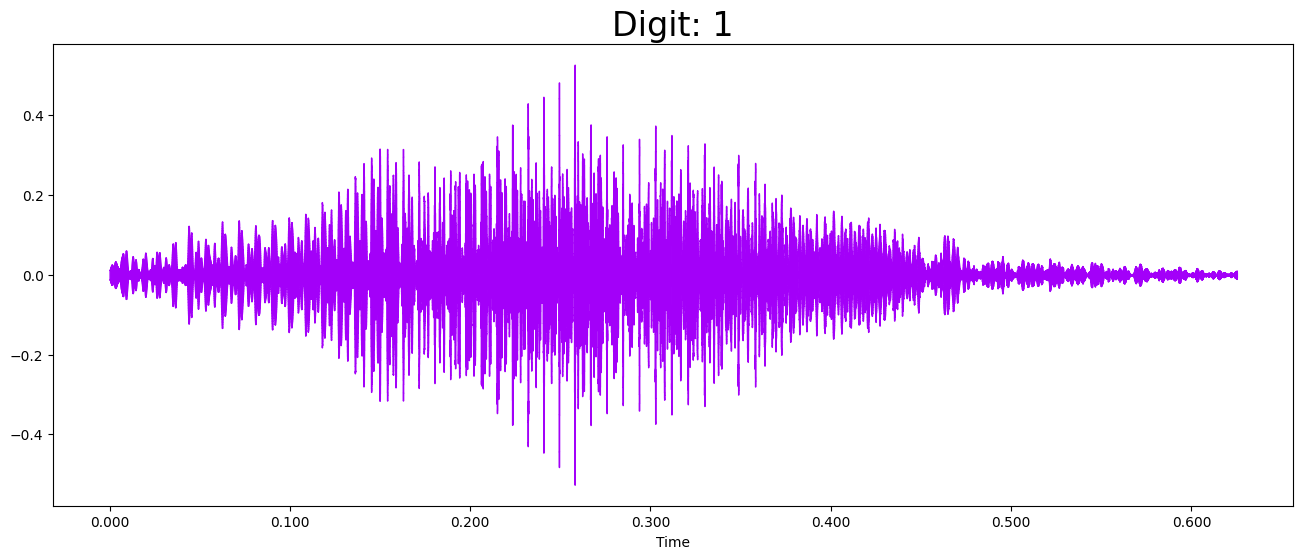

In [47]:
visualize_digit(3, 1)

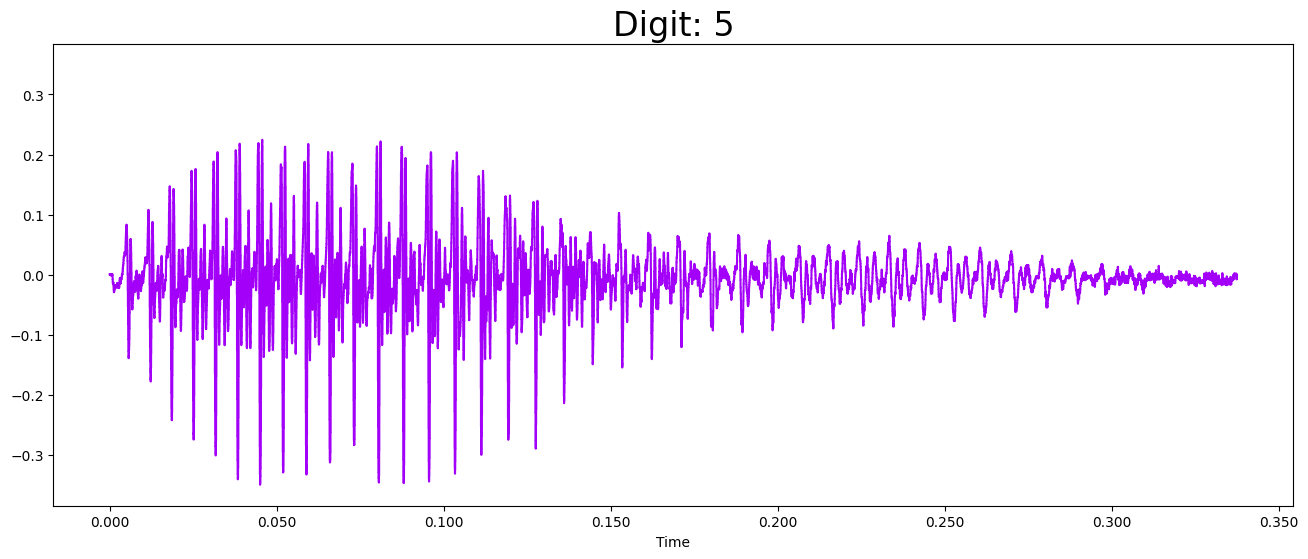

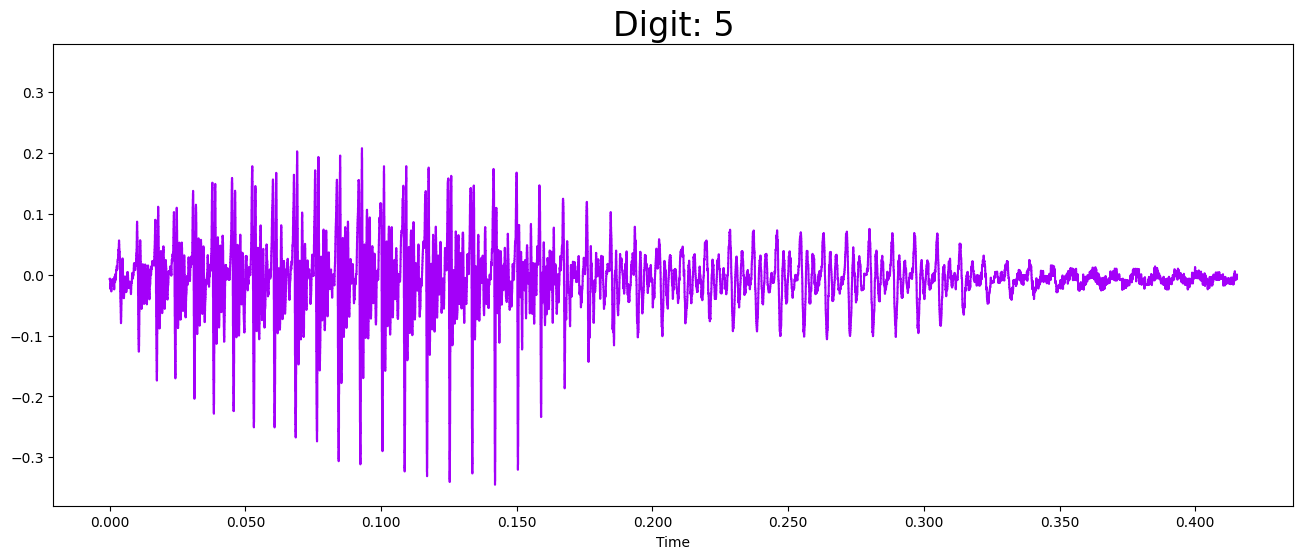

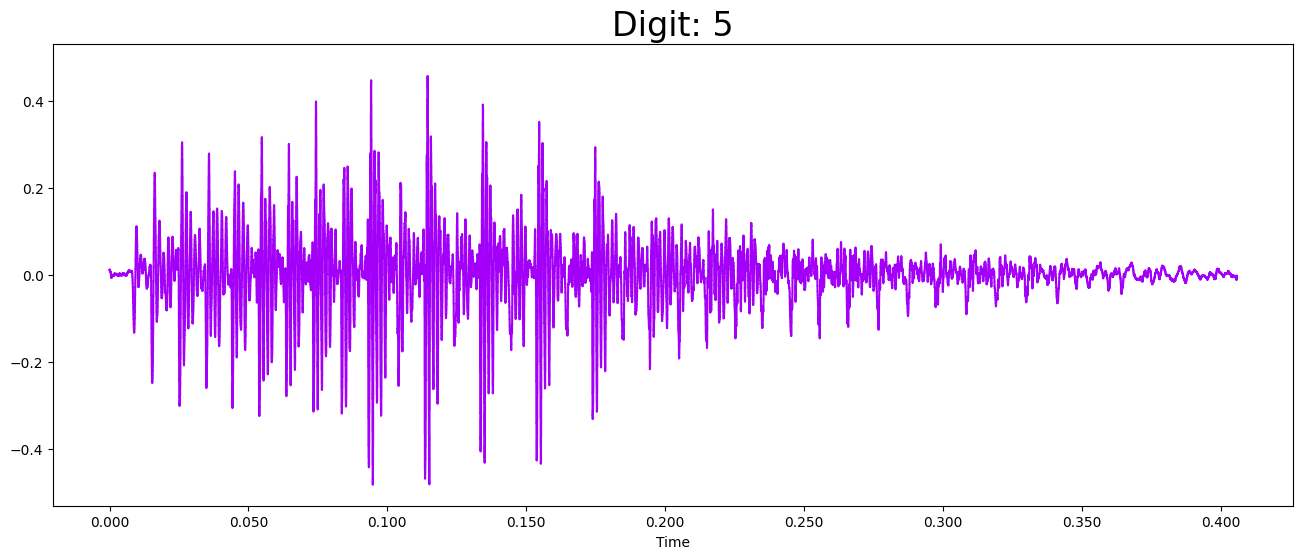

In [48]:
visualize_digit(3, 5)

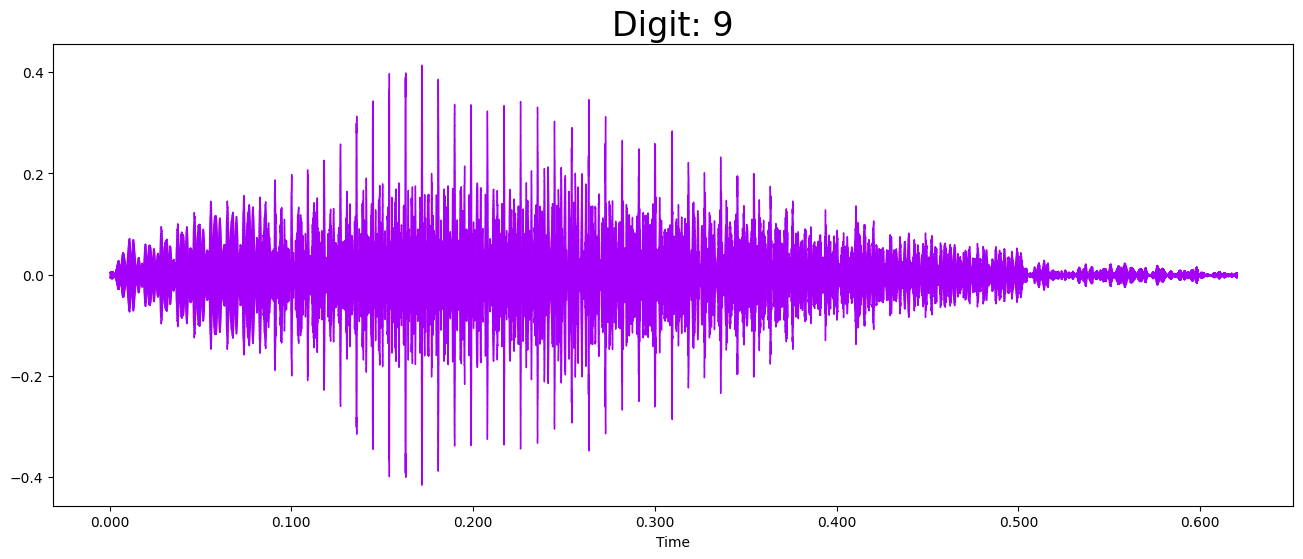

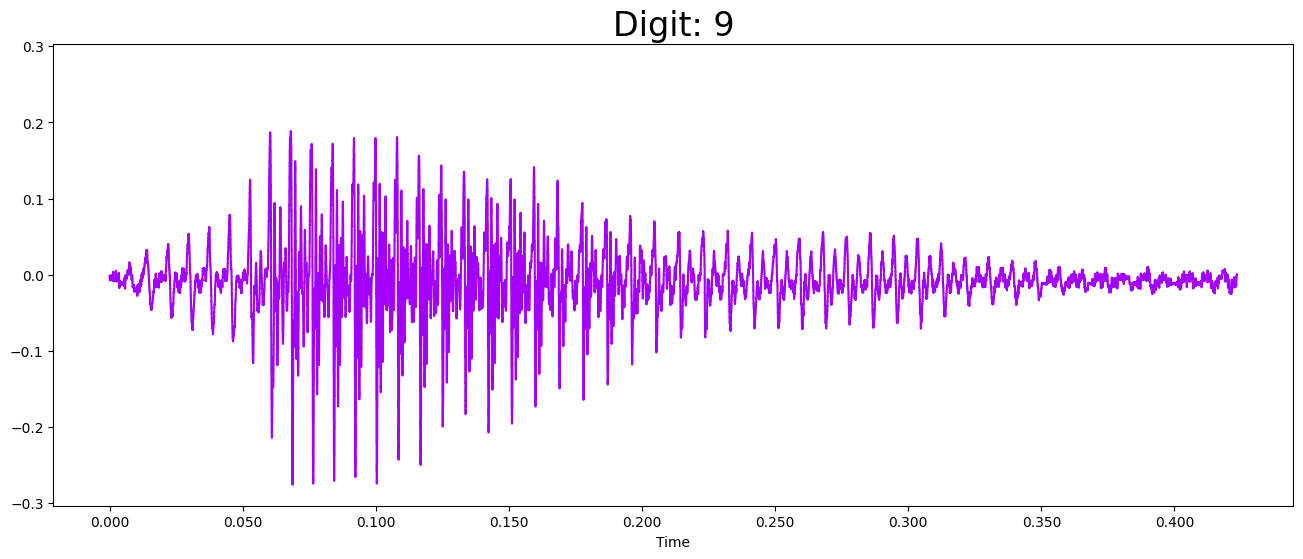

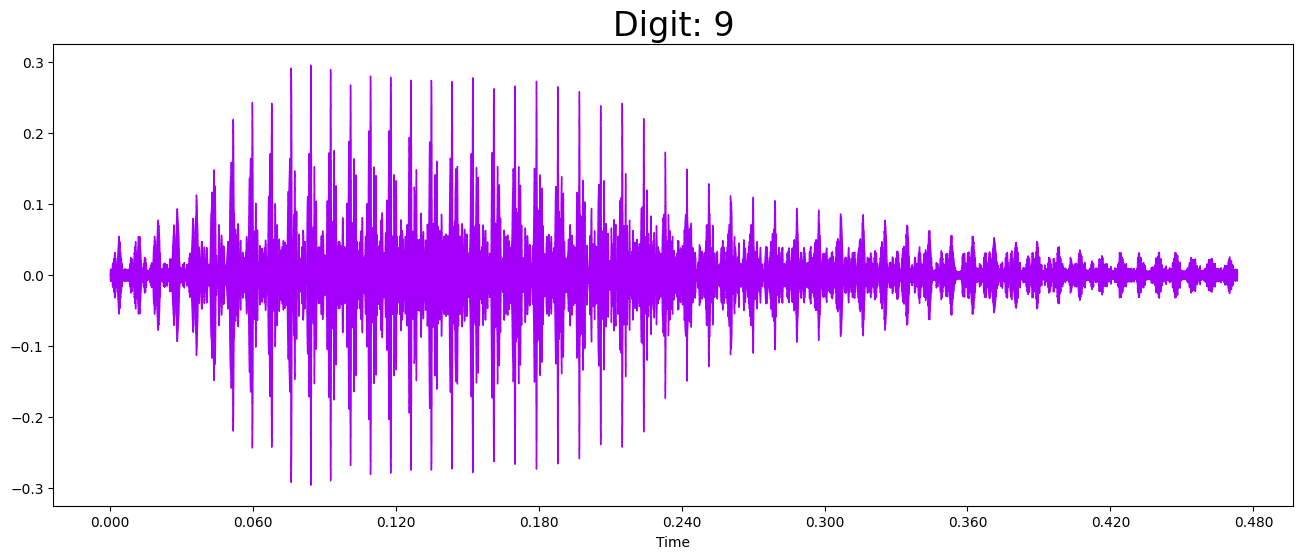

In [49]:
visualize_digit(3, 9)

# Data Processing

## Calculating the "spectral centroid" for the digits and then printing out the mean of the centroid for each digit.

*Spectral Centroid* indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in each sound wave in the dataframe.

In [65]:
centroids = []
frames_to_time = []
for i in tqdm(os.listdir(record_path)):
    # method to load all the audio files from directory and calc frame rate
    raw_data,frame_rate=librosa.load(record_path+i)
    # method to infer duration from data and frame rate using librosa
    centroid=librosa.feature.spectral_centroid(y=raw_data,sr=frame_rate)[0]
    # inserting the extracted data into the dataframe
    centroids.append(centroid) # i.split is the file name (digit name)
    #method to extract list of frames in time
    frames = range(len(centroid))
    t_frames=librosa.frames_to_time(frames)
    frames_to_time.append(t_frames)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [51]:
audio_df['centroids'] = centroids

In [66]:
audio_df['t_frames'] = frames_to_time

In [67]:
audio_df.head()

,raw_data,frame_rate,duration,digit,centroids,t_frames
0,"[0.0007090622, 8.305741e-05, -0.0008284228, -0...",22050,0.337415,5,"[905.2050093908301, 968.5958093869538, 995.671...","[0.0, 0.023219954648526078, 0.0464399092970521..."
1,"[4.3985827e-05, -0.00015679716, -0.00040316404...",22050,0.305760,3,"[2140.7253084582403, 1617.5586853415198, 809.8...","[0.0, 0.023219954648526078, 0.0464399092970521..."
2,"[-0.00052017445, -0.00063179934, -0.0005419, -...",22050,0.337007,1,"[1498.767656890672, 1314.392835083596, 692.855...","[0.0, 0.023219954648526078, 0.0464399092970521..."
3,"[-0.0016748044, -0.0023194065, -0.0016845848, ...",22050,0.319501,2,"[2174.0083392935385, 1050.1677789779947, 849.1...","[0.0, 0.023219954648526078, 0.0464399092970521..."
4,"[-5.8825585e-06, 2.0447591e-05, 6.755755e-05, ...",22050,0.383129,4,"[745.9673761414242, 731.3680649731832, 712.070...","[0.0, 0.023219954648526078, 0.0464399092970521..."


In [68]:
def visualize_digit_centroid(num_to_plot, digit_to_plot):
    num_plots = 0
    # removing 1 bc of zero indexing
    num_to_plot -= 1
    # Function that normalizes the Sound Data
    def normalize(x, axis=0):
        return minmax_scale(x, axis=axis)
    for i in range(len(audio_df)):
        digit = audio_df.iloc[i, 3]
        if digit == str(digit_to_plot):
            plt.figure(figsize = (16, 6))
            raw_data = audio_df.iloc[i, 0]
            frame_rate= audio_df.iloc[i, 1]
            centroid = audio_df.iloc[i, 4]
            t_frames = audio_df.iloc[i, 5]
            librosa.display.waveshow(y = raw_data, sr = frame_rate, color = "#A300F9")
            plt.plot(t_frames, normalize(centroid), color='#FFB100')
            plt.title('Digit: ' + digit, fontsize=24)
            plt.show()
            if num_plots == num_to_plot:
                break
            num_plots += 1

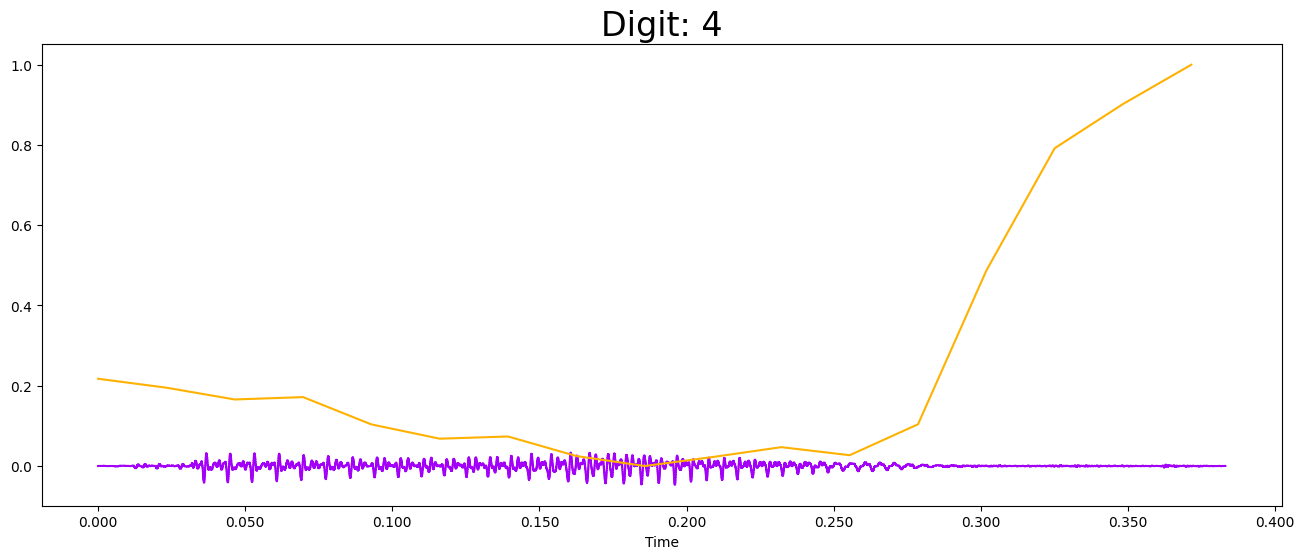

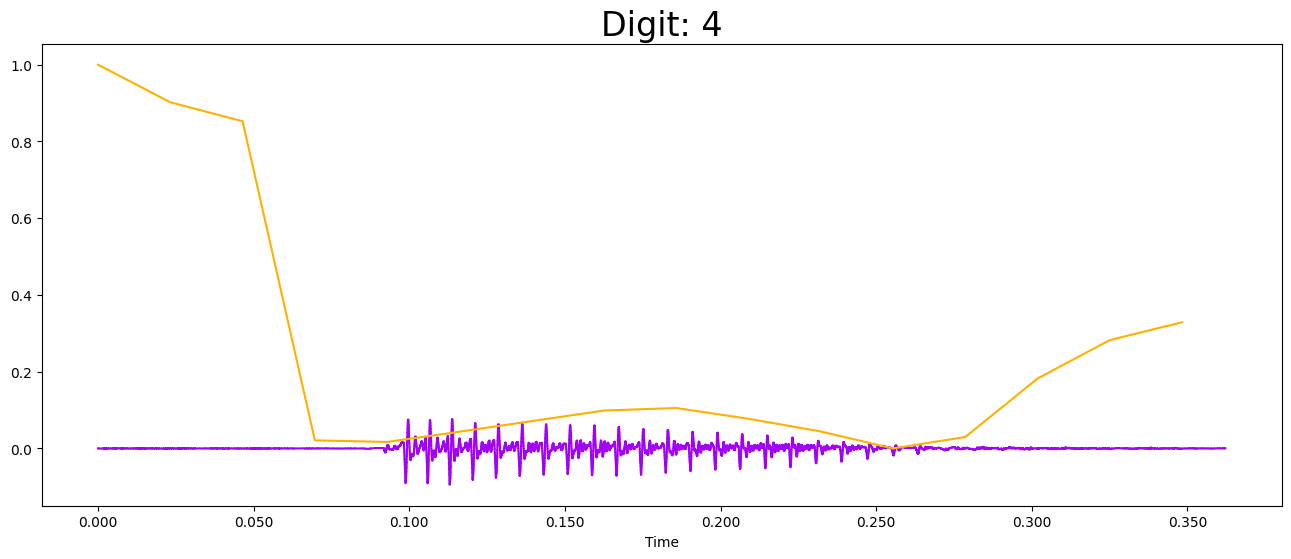

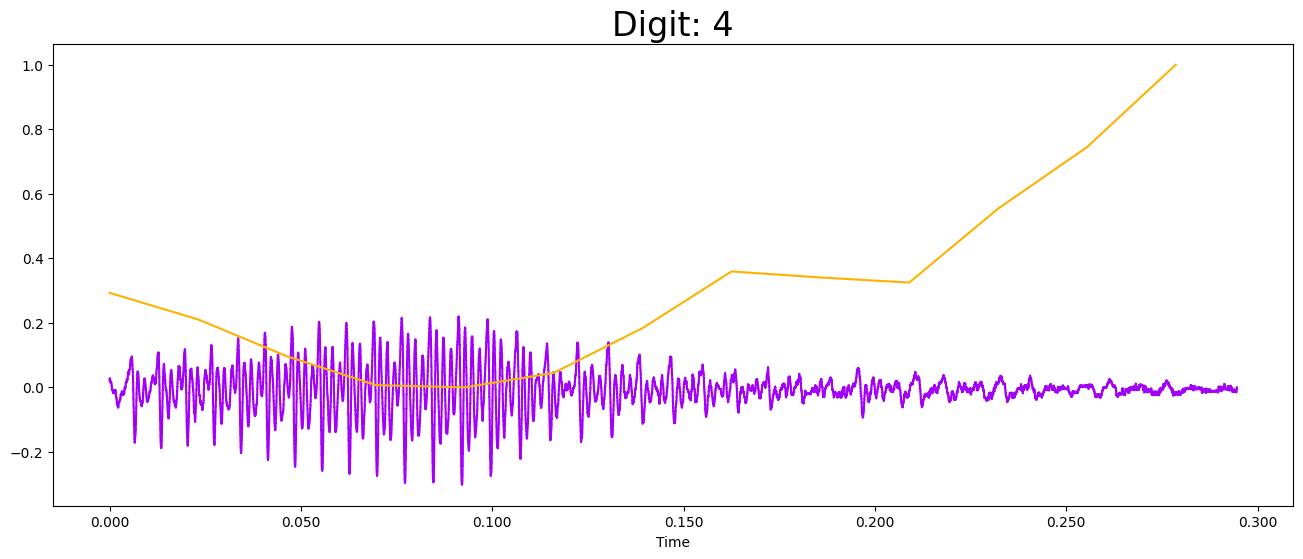

In [69]:
visualize_digit_centroid(3, 4)

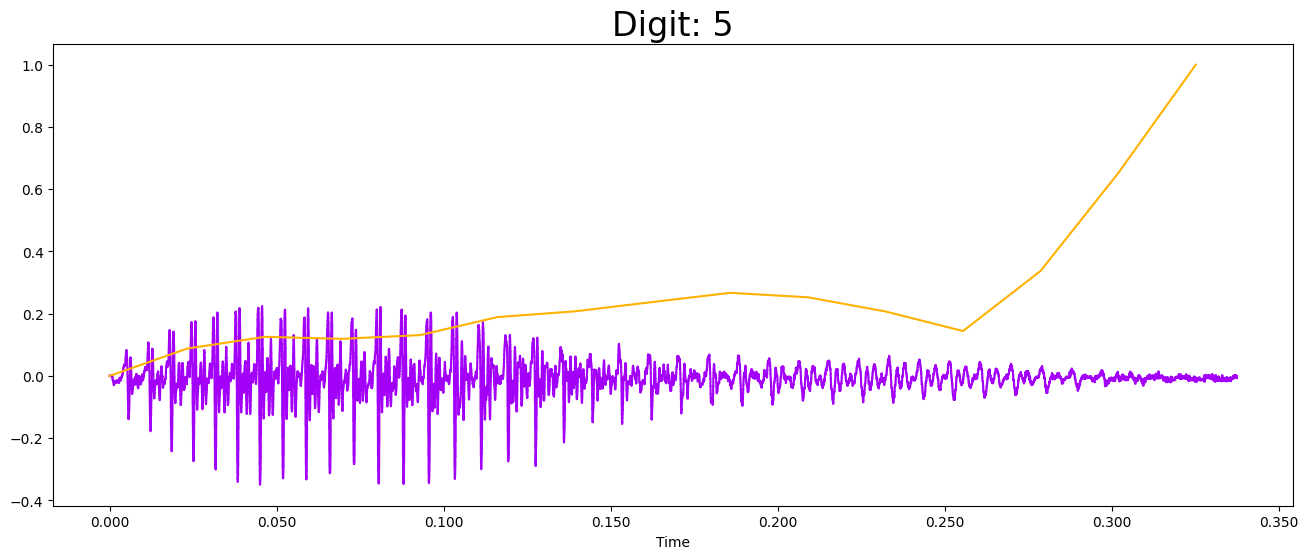

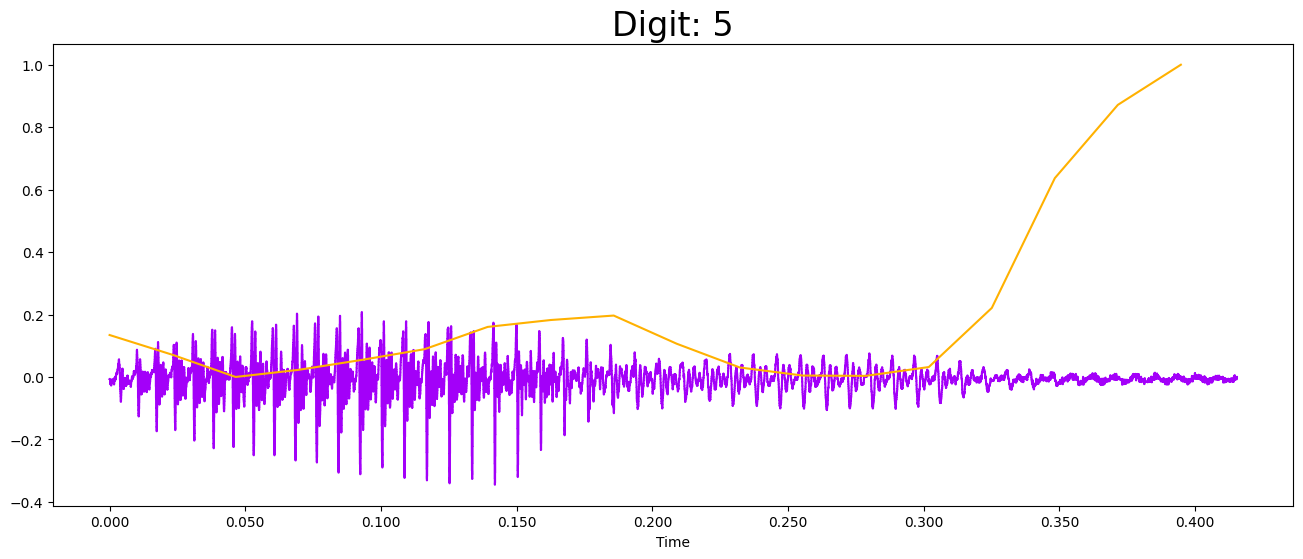

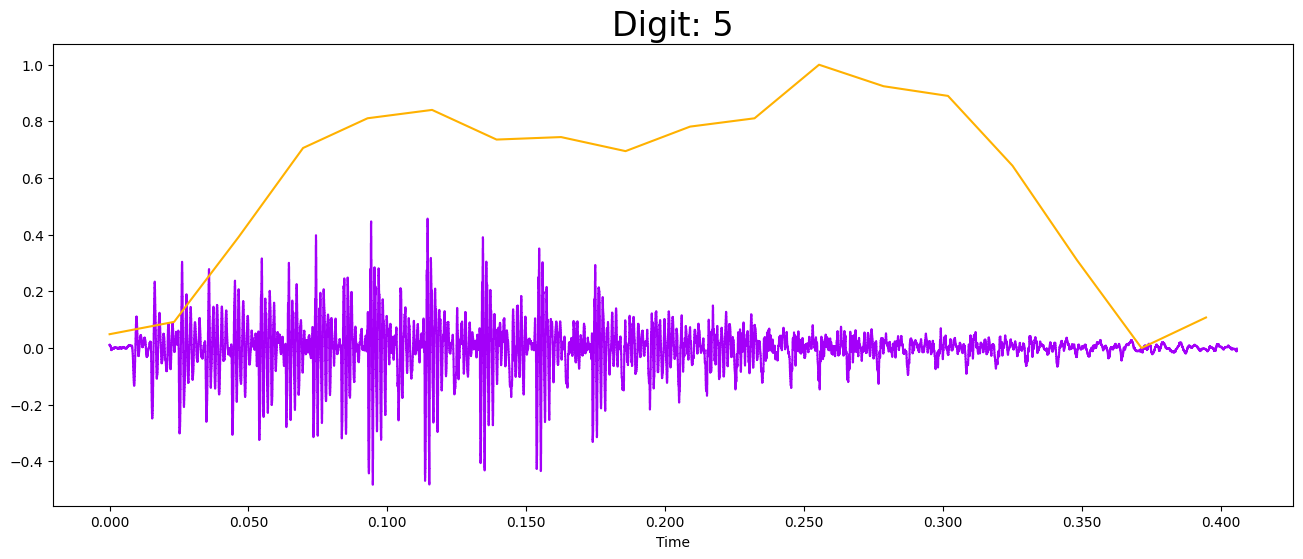

In [70]:
visualize_digit_centroid(3, 5)

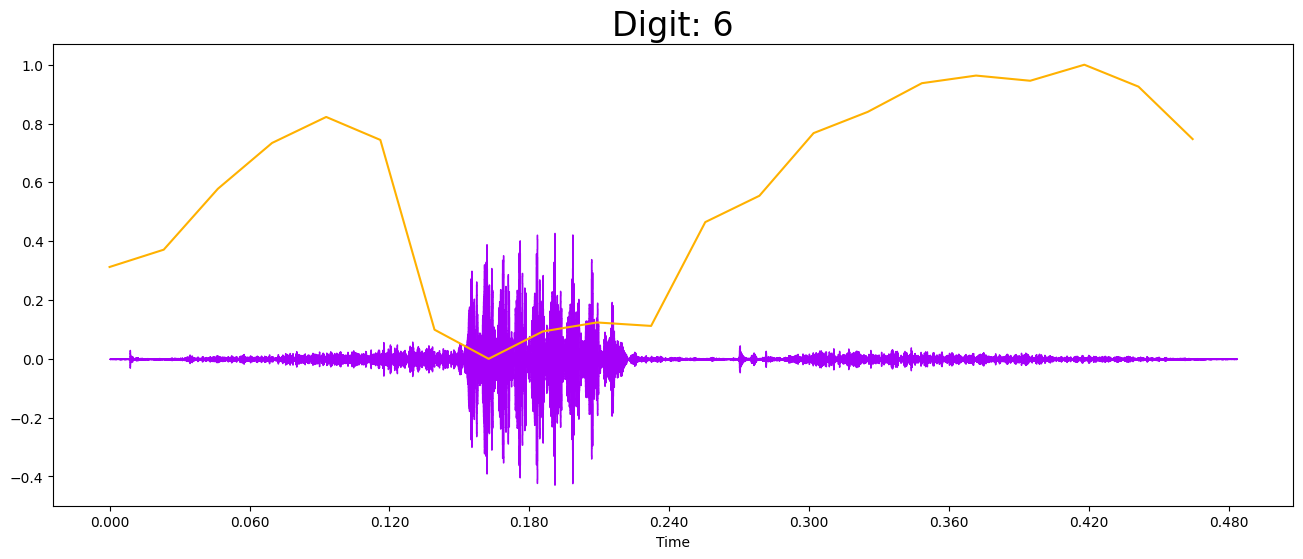

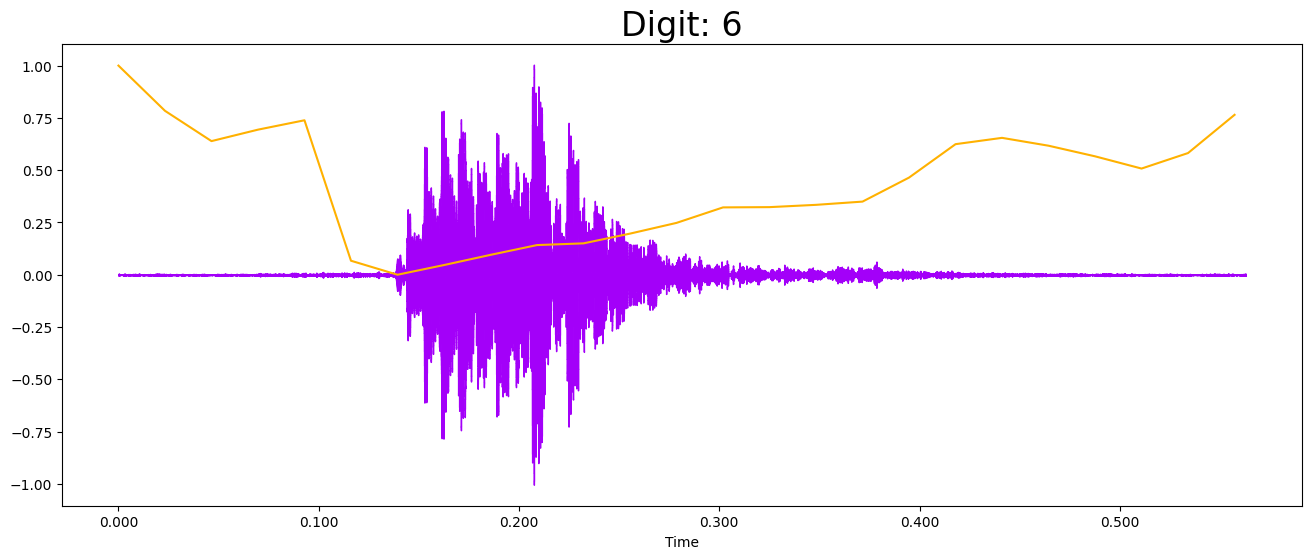

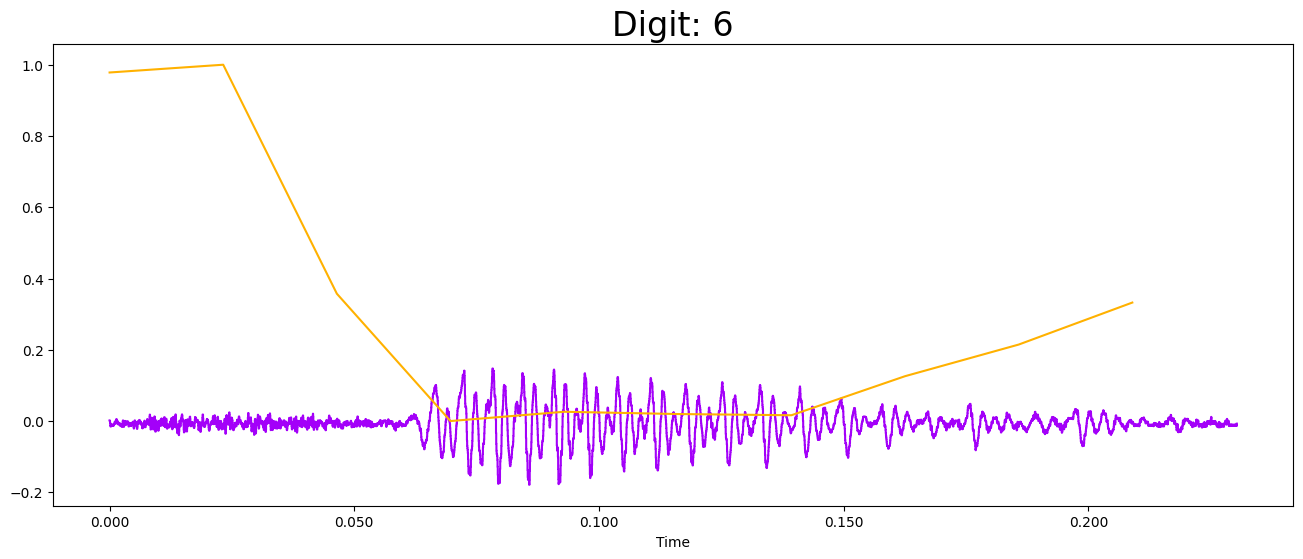

In [71]:
visualize_digit_centroid(3, 6)